## Model outcomes and functional check
Now that we have confidence that the MCMC has worked, it is of course paramount that we check that the outcomes make sense. 

### Individual parameter estimates
Firstly, let's have a quick look at the summary. We see that all parameters are positive, except for the `recency_effect_exponent` (which is not a size anyway) and the `sharing_effect` (duets are supposed to have a smaller boost), which is as we expect. 
Furthermore, we see that all parameters are on the same scale - there is no single paramtere dominating all the others - and there are no parameters with huge standard deviations. So far, so good.

In [80]:
az.summary(multilevel_noncentered_model_idata, var_names=['~za_artist', '~a_artist', '~mu_artist'], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.400,0.117,0.180,0.624,0.001,0.001,9353.519,11521.757,1.000
recency_effect_exponent,-1.694,0.362,-2.387,-1.074,0.007,0.006,4587.192,2237.134,1.000
max_recency_effect,1.131,0.326,0.628,1.631,0.006,0.006,7217.150,3448.408,1.001
effect_popularity,0.378,0.106,0.173,0.570,0.001,0.001,10716.311,13665.353,1.000
history_effect,0.031,0.009,0.013,0.048,0.000,0.000,11812.787,14099.239,1.000
age_passing_effect,0.009,0.004,0.002,0.017,0.000,0.000,12295.807,12760.470,1.000
is_dutch_effect,0.073,0.138,-0.173,0.348,0.001,0.001,11652.990,12499.509,1.000
sharing_effect,-0.272,0.107,-0.472,-0.069,0.001,0.000,26654.509,15100.810,1.000
within_oeuvre_effect,0.016,0.122,-0.211,0.246,0.001,0.001,39914.262,14730.294,1.000
sigma_a,0.238,0.049,0.150,0.333,0.001,0.000,7740.553,11517.099,1.000


To get more feeling with the parameter values, we compare them to our priors; what we believed to be true beforehand. Generally, we expect the posterior parameters to be tighter that the priors and in the same region. Furthermore, we look at whether the shape of the parameter distributions is approximately correct.

Technically, we can again use the InferenceData and add the data. Then `arviz`-package has out-of-the-box functions that compare the prior and the posterior. Sampling from the prior is just as easy: just call `pm.sample_prior_predictive` within a model context.

In [81]:
with multilevel_noncentered_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
multi_prior = az.from_dict(prior={k: v.T for k, v in prior_checks.items() if k != 'y_like'})
multilevel_noncentered_model_idata.extend(multi_prior)

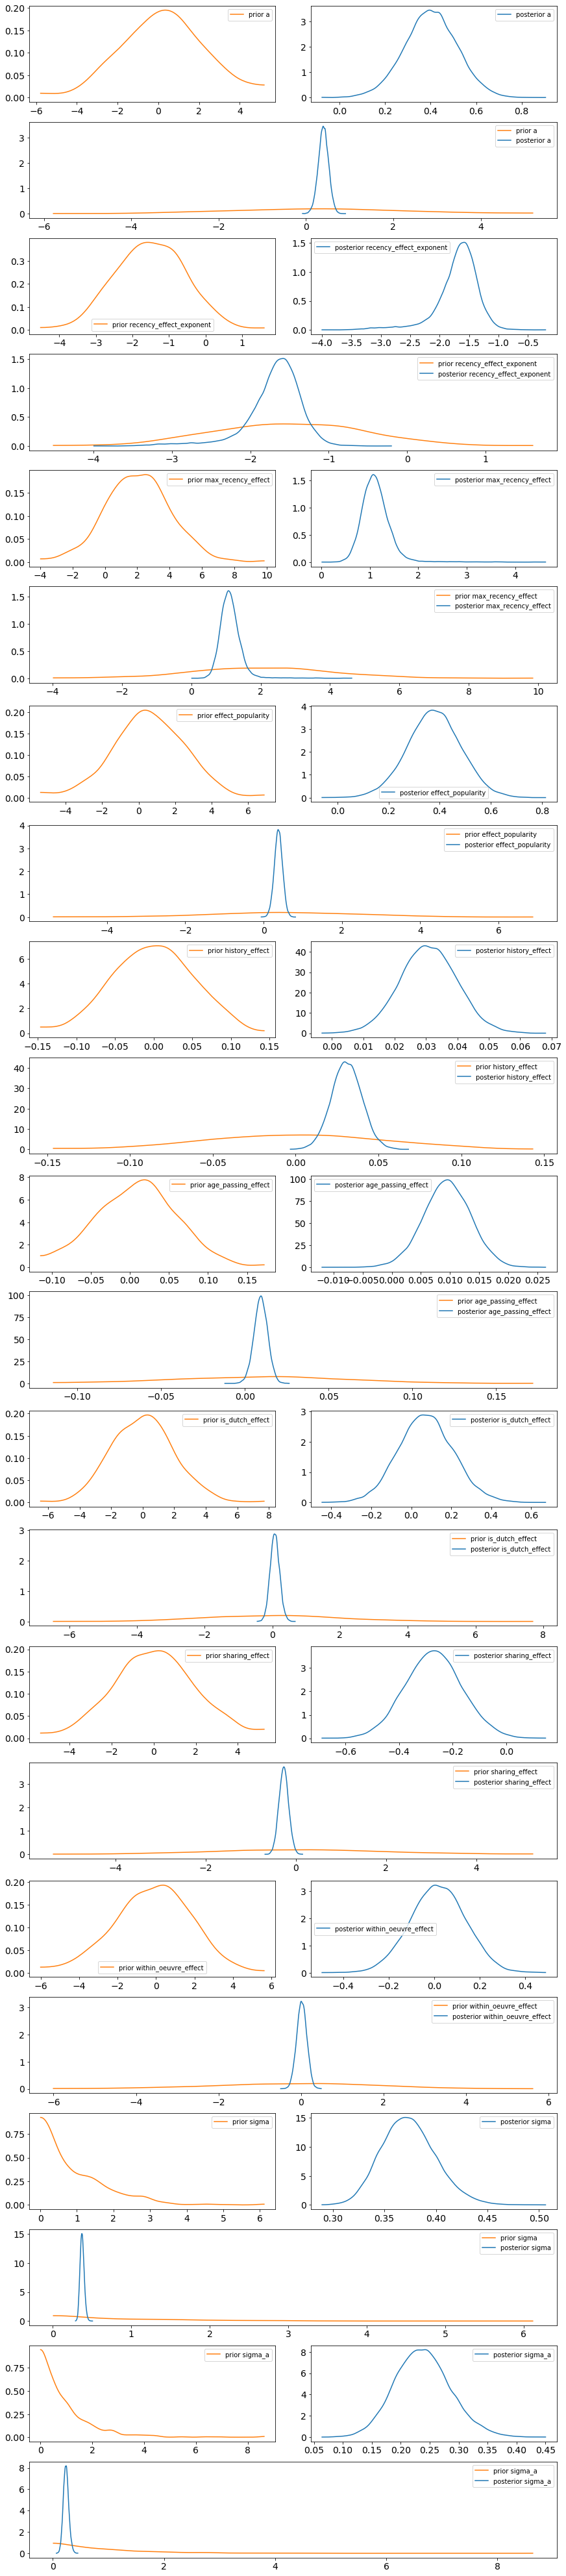

In [82]:
vars_priors = ['a',
               'recency_effect_exponent',
               'max_recency_effect',
               'effect_popularity',
               'history_effect',
               'age_passing_effect',
               'is_dutch_effect',
               'sharing_effect',
               'within_oeuvre_effect',
               'sigma',
               'sigma_a',
              ]

axes = az.plot_dist_comparison(multilevel_noncentered_model_idata, var_names=vars_priors, figsize=(12, 5*len(vars_priors)))
plt.savefig('Prior_vs_posterior.png')

We see that the posteriors are indeed more constrained than, and in line with the priors. One point of interest is that the history effect seems to be slightly informed by the prior - this is not generally a bad thing, but this prior is not very well substantiated, so we could have considered widening it a bit. Other than that, everything seems to be fine.

Next we look at whether the parameters are significantly different from 0. This turns out to be the case for all parameters except for `is_dutch_effect` and `within_oeuvre_effect`.

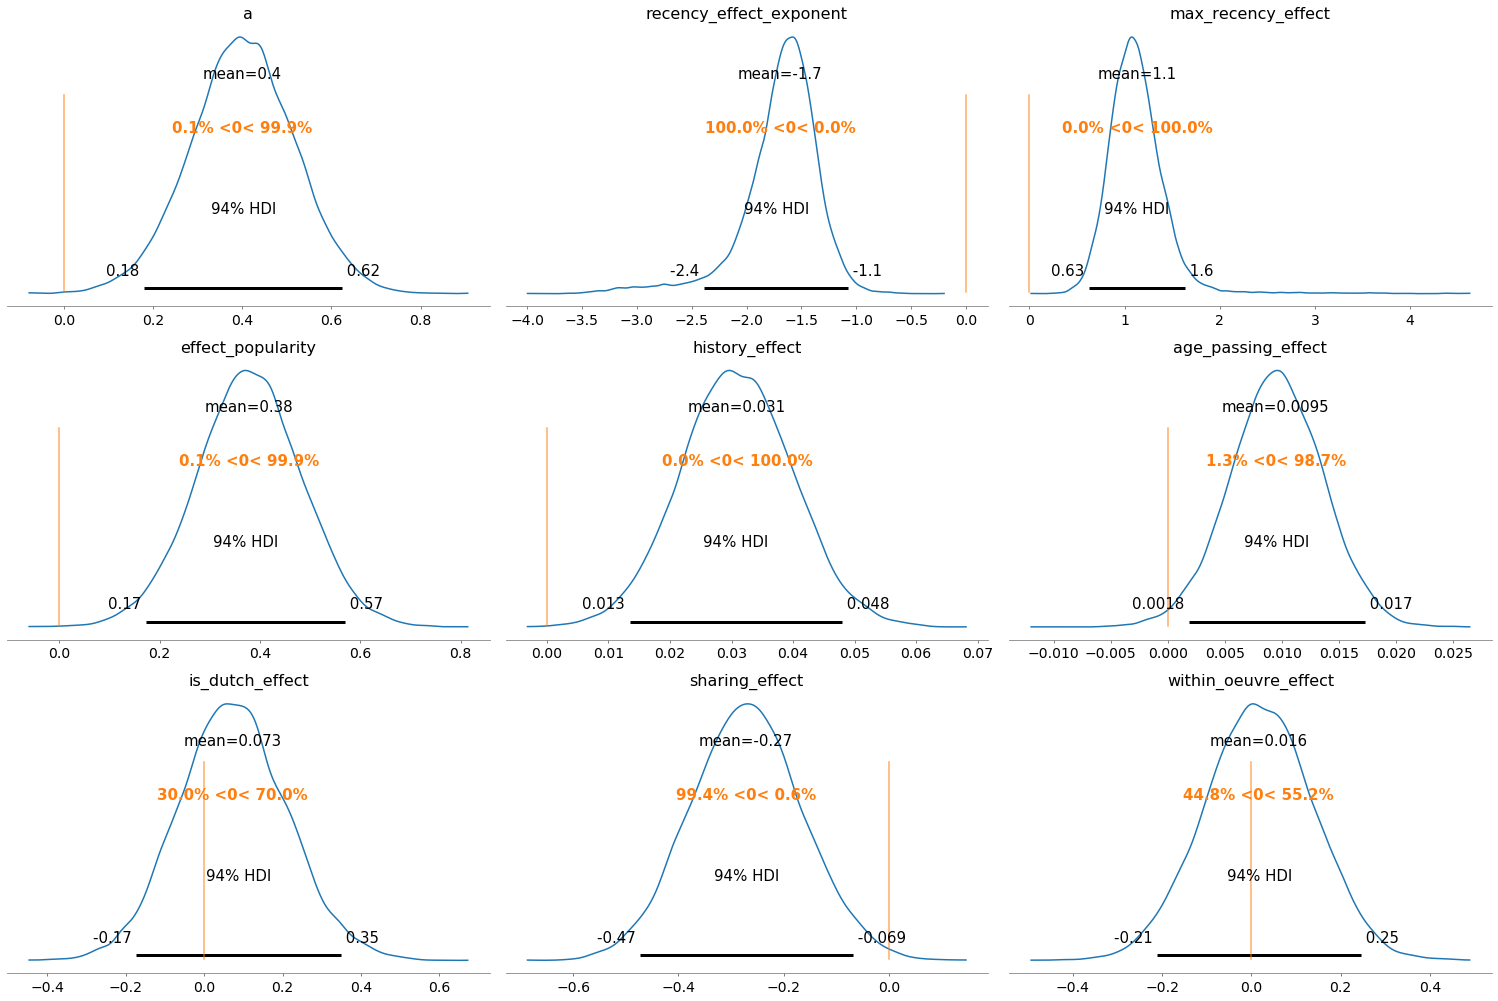

In [83]:
axes = az.plot_posterior(multilevel_noncentered_model_idata, ref_val=0, var_names=var_names)

#### Understanding the recency effect

A slightly more difficult instance to look at is the recency effect, since it consists of two parameters: a recency effect exponent (determining the shape) and the maximum effect (determining the height). We sample from the posterior to get full lines that estimate the effect, which give us insight into the best estimate of the full effect, as well as the uncertainty

In [84]:
parameters = multilevel_noncentered_model_idata.posterior.to_dataframe()

In [85]:
outcomes = {}
days = np.arange(-365, 0)

parameters_without_groups = parameters.droplevel('Artist').loc[lambda x: ~x.index.duplicated()]

for i, row in parameters_without_groups.iterrows():
    recencyeffect = (np.exp(10**row['recency_effect_exponent'] * days) - np.exp(10**row['recency_effect_exponent'] * -365))* row['max_recency_effect']
    outcomes[i] = recencyeffect

In [86]:
df_recencyeffect = pd.DataFrame(outcomes, index=np.arange(-365, 0)).apply(np.exp)

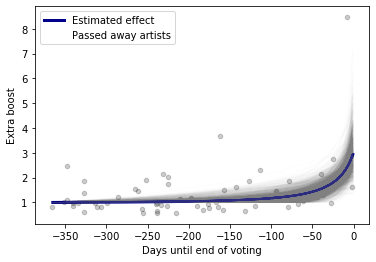

In [87]:
N_lines = 1500
fig, ax = plt.subplots()
df_recencyeffect.mean(axis='columns').plot(ax=ax, lw=3, c='darkblue', label='Estimated effect')
(df_artist.assign(RecencyEffect = lambda df: df['Boost']/df['Boost'].median())
          .query('DaysToStemperiode > -400')
          .plot(x='DaysToStemperiode', y='RecencyEffect', kind='scatter', ax=ax, c='k', alpha=0.2, label='Passed away artists')
)
plt.legend()
df_recencyeffect.sample(N_lines, axis='columns').plot(c='grey', alpha=0.01, legend=False, ax=ax)

ax.set_xlabel('Days until end of voting')
ax.set_ylabel('Extra boost')
plt.savefig('Boost_vs_recency.png')

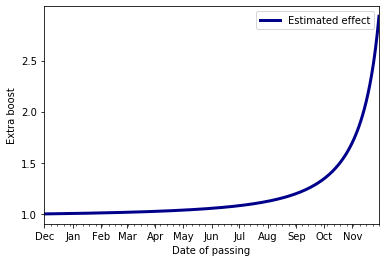

In [88]:
def convert_to_date(days_from_date, reference_date='2020-12-01'):
    return pd.Timestamp(reference_date) + pd.Series([pd.Timedelta(i, 'days') for i in days_from_date], index=days_from_date)

ax =  (df_recencyeffect.mean(axis='columns').to_frame()
     .assign(Date = lambda df: convert_to_date(df.index))
     .plot(x='Date', y=0, lw=3, c='darkblue', label='Estimated effect')
    )

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.ylabel('Extra boost')
plt.xlabel('Date of passing')
plt.yticks([1, 1.5, 2, 2.5])
plt.savefig(os.path.join(FOLDER_OUTPUT, 'recency_effect.jpg'))

In [89]:
days_to_use = [-365,
               *range(-350, -50, 50),
               *range(-70, -10, 7),
               *range(-10, 0, 2),
              ]
df_recencyeffect.quantile([0.025, 0.16, 0.5, 0.84, 0.975], axis='columns').loc[:, days_to_use]

,-365,-350,-300,-250,-200,-150,-100,-70,-63,-56,...,-42,-35,-28,-21,-14,-10,-8,-6,-4,-2
0.025,1.0,1.000000,1.000000,1.000000,1.000001,1.000027,1.000963,1.008064,1.013465,1.022050,...,1.060954,1.103434,1.172108,1.290532,1.456997,1.567630,1.615387,1.668201,1.709137,1.738130
0.160,1.0,1.000000,1.000007,1.000053,1.000392,1.002910,1.021548,1.072397,1.096256,1.128597,...,1.232225,1.315776,1.428915,1.576437,1.766570,1.897697,1.969658,2.041905,2.117379,2.191639
0.500,1.0,1.000107,1.000897,1.003360,1.011120,1.035374,1.115254,1.239077,1.285068,1.341480,...,1.492072,1.594794,1.721763,1.887775,2.109733,2.277044,2.375738,2.489697,2.614564,2.757750
0.840,1.0,1.003084,1.017995,1.044552,1.091293,1.177451,1.341752,1.516407,1.571735,1.636503,...,1.796011,1.903897,2.042084,2.226741,2.497439,2.718034,2.857457,3.023438,3.232455,3.478931
0.975,1.0,1.018930,1.088879,1.173655,1.278549,1.415782,1.619149,1.803090,1.863848,1.929932,...,2.105395,2.229569,2.393212,2.601814,2.943292,3.242943,3.440750,3.676292,3.983652,4.400830


### Joint distributions
After looking at all parameters indivudally, I look at the parameters in joint distribution, which reveals linear and non-linear correlations. We see mostly very regular joint distributions, but the recency effects have a very interesting 'whale-like' distribution: a mostly positive correlation, which turns into a negative correlation for very small exponents.

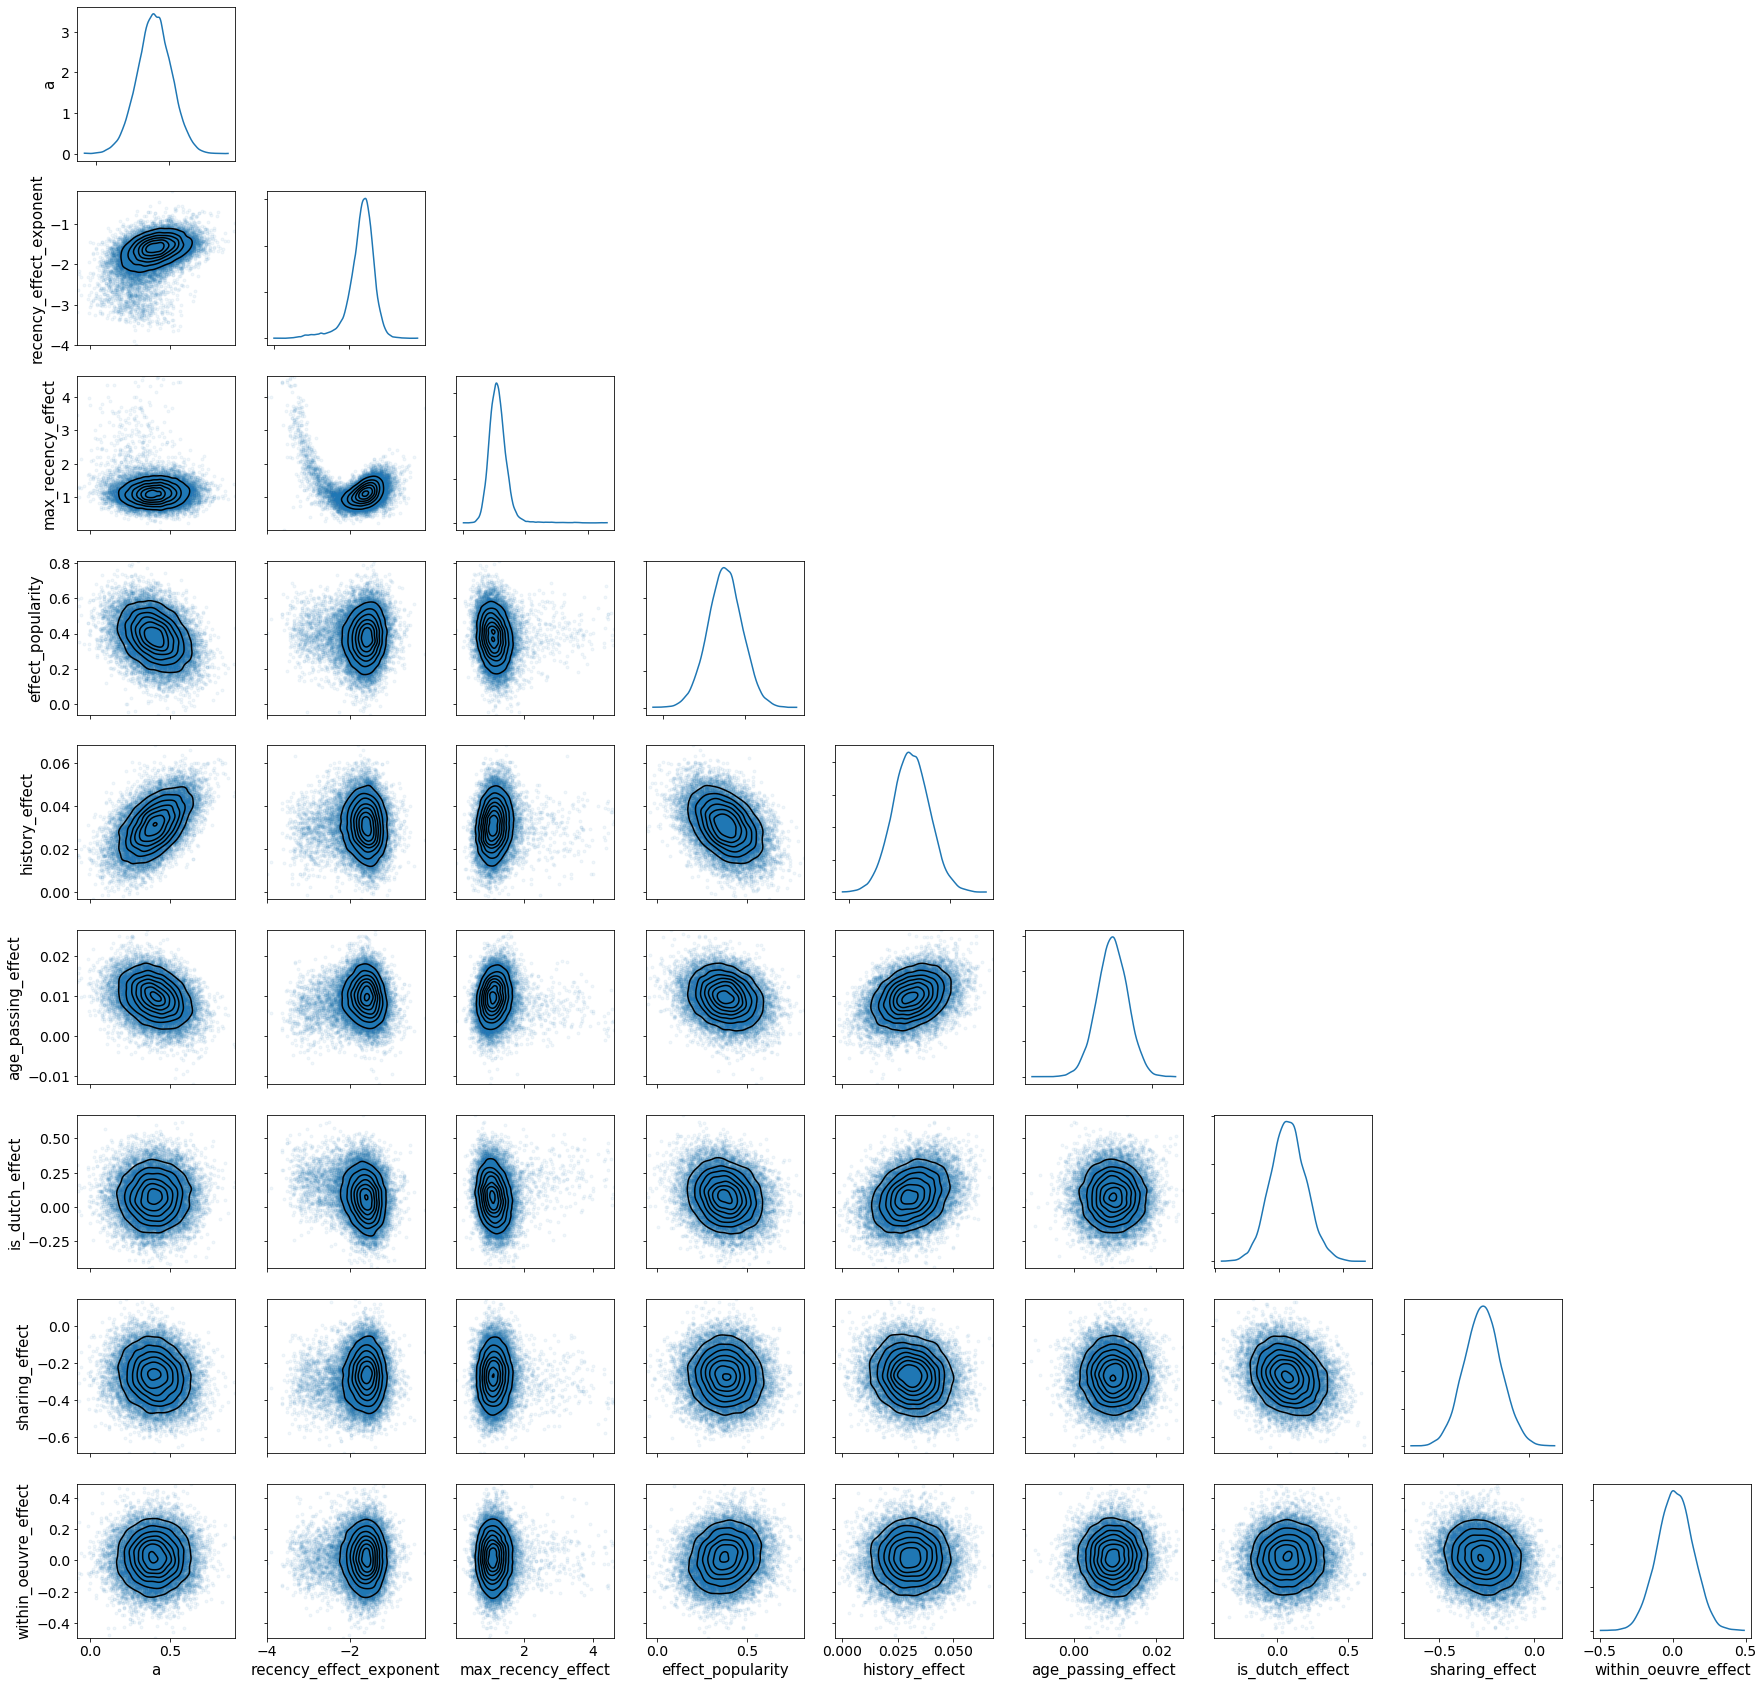

In [90]:
az.rcParams['plot.max_subplots'] = 100  # Since we have many parameters, the number of subplots is larger than the default - allow az to take more time plotting
_ = az.plot_pair(multilevel_noncentered_model_idata,
                var_names=var_names, marginals=True,
                divergences=True,
                kind=['scatter', 'kde'],
                figsize=(30, 30),
                scatter_kwargs={'alpha': 0.06})

In [91]:
def plot_correlations(df):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(df.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.1%', ax=ax, cbar=False)
    return ax

To quantify this a bit, lets look into the (linear) correlations of the parameters of the effects

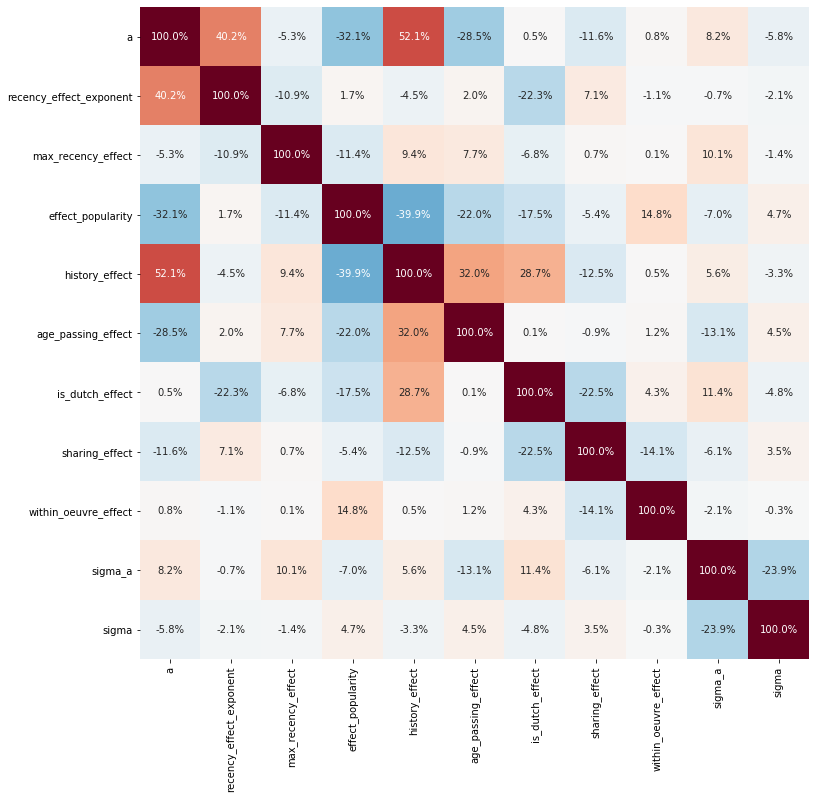

In [92]:
plot_correlations(parameters_without_groups.drop(columns=['za_artist', 'mu_artist', 'a_artist']))

We see a number of interesting things:
* There is a strong degeneracy between $a$ and $\textrm{history_effect}$, which means that the model finds it easier to determing the boost further out in the past
* Interestingly, the correlation coefficient is quite small between $\textrm{max_recency_effect}$ and $\textrm{recency_effect_exponent}$. While they are strongly correlated, they are not _linearly_ correlated.

#### The importance of artist deviation



## Fit/prediction quality

Now that we have a good understanding of the fit, working and parameters of our model, it is finally time to look at the predictions. To do this  we sample from the posterior predictive, which means we use every sample from our MCMC chain, and calculate what the predicted value is for boost. We do in this in two ways:


In [94]:
%%time
with multilevel_noncentered_model:
    ppc = pm.fast_sample_posterior_predictive(multilevel_noncentered_model_idata)
    # fast_sample throws a mysterious error when dropping some vars
    ppc_no_artist = pm.sample_posterior_predictive(multilevel_noncentered_model_idata.posterior.drop_vars(['mu_artist', 'a_artist', 'za_artist']))
    
predictions = pd.DataFrame(ppc['y_like'].T, index=df.index)
predictions_no_artist = pd.DataFrame(ppc_no_artist['y_like'].T, index=df.index)

Wall time: 3min 18s


In [95]:
predictions_agg = (pd.concat([predictions.quantile([0.16, 0.5, 0.84], axis='columns').transpose(),
                              df['LogBoost']], axis='columns')
                   .rename(columns={0.5: 'yhat'})
                  )

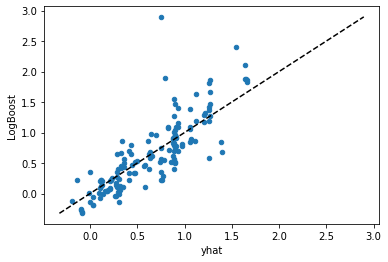

In [96]:
ax = predictions_agg.plot(x='yhat', y='LogBoost', kind='scatter')
valmin, valmax = predictions_agg[['LogBoost', 'yhat']].min().min(), predictions_agg[['LogBoost', 'yhat']].max().max()
ax.plot([valmin, valmax], [valmin, valmax], 'k--')
plt.show()

In general, the predicted boost matches the actual boost very well. For easier interpretation, let's transform back to the linear space

In [97]:
predictions_exp = predictions_agg.apply(np.exp).rename(columns={'LogBoost': 'Boost'})

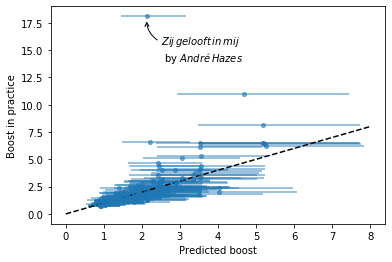

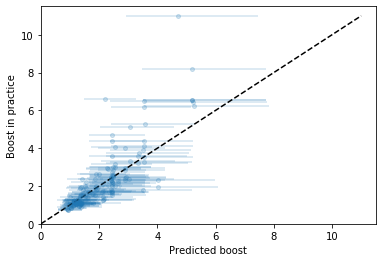

In [98]:
plt.errorbar(predictions_exp['yhat'], predictions_exp['Boost'],
             xerr=[predictions_exp['yhat'].sub(predictions_exp[0.16]), predictions_exp[0.84].sub(predictions_exp['yhat'])],
             ls=' ', marker='o', alpha=0.6, ms=4)
plt.gca().annotate('$\it{Zij\/gelooft\/in\/mij}$\n by $\it{André\/Hazes}$', (2.123288,17.81695), (2.5, 14),
                   arrowprops=dict(arrowstyle="->", connectionstyle= "angle3,angleA=0,angleB=90"),
)
plt.plot([0, 8], [0, 8], 'k--')
plt.ylabel('Boost in practice')
plt.xlabel('Predicted boost')
plt.savefig(os.path.join(FOLDER_OUTPUT, 'Allboosts_compared.jpg'))
plt.show()
plt.errorbar(predictions_exp['yhat'], predictions_exp['Boost'],
             xerr=[predictions_exp['yhat'].sub(predictions_exp[0.16]), predictions_exp[0.84].sub(predictions_exp['yhat'])],
             ls=' ', marker='o', alpha=0.2, ms=4)
plt.plot([0, 11], [0, 11], 'k--')
plt.ylabel('Boost in practice')
plt.xlabel('Predicted boost')
plt.ylim(0, 11.5)
plt.xlim(0, 11.5)
plt.savefig(os.path.join(FOLDER_OUTPUT, 'boostcompared.jpg'))

We see that almost all predictions are very well, but _Zij gelooft in mij_ is very off, which may require further investigation in the future, such as investigating extra effects that explain the huge boost (e.g. a $\textrm{chanelling}$ effect where the boost is channeled through a single song instead of through all songs) or a different model such as a Students-T-distribution instead of a Normal distribution.

To get a better picture of the performance of our model, we compare three types of predictions:
* The full model, which gives us insight in the quality of the model
* The model without the artist specific measures, which can only be estimate _after the death_ of an artist; this will give us more insight in how well we can expect to predict out of sample
* The model based solely on the mean parameters, which loses a lot of information about the uncertainty, but is easier to reason about #TODO explain mean = expectation value

In [99]:
b = top2000analysis.BoostExplainer(parameters.mean(), multilevel_noncentered_model_idata)

In [100]:
posterior = (df
              .assign(yhat = predictions.mean(axis='columns'),
                      error = lambda df: df['yhat'].sub(df['LogBoost']),
                      abserror = lambda df: df['error'].abs(),
                      yhat_no_artist = predictions_no_artist.mean(axis='columns'),
                      error_without_artisteffect = lambda df: df['yhat_no_artist'].sub(df['LogBoost']),
                      abserror_without_artisteffect = lambda df: df['error_without_artisteffect'].abs(),
                      improvement_artisteffect = lambda df: df['abserror_without_artisteffect'].sub(df['abserror']),
                      yhat_mean_params = lambda df: np.log([b.all_effects(i)['EffectSize'].prod() for i in range(len(df))]),
                      error_mean_params = lambda df: df['yhat_mean_params'].sub(df['LogBoost']),
                      abserror_mean_params = lambda df: df['error_mean_params'].abs(),
                     )
            )

In [101]:
posterior.nlargest(10, 'abserror').filter(['Year', 'Rank', 'Title', 'NameArtist', 'Boost', 'LogBoost', 'yhat'])

,Year,Rank,Title,NameArtist,LogBoost,yhat
14199,2004,30.0,Zij gelooft in mij,André Hazes,2.896006,0.756325
10797,2017,135.0,Somebody to Love,George Michael,1.887624,0.790827
25792,2015,90.0,Ben ik te min,Armand,2.397131,1.544221
7136,2009,6.0,Pastorale,Ramses Shaffy,0.678758,1.398399
8806,2009,1090.0,One Day in Your Life,Michael Jackson,0.579711,1.254374
1777,2016,254.0,Sometimes It Snows in April,Prince & The Revolution,1.542210,0.886770
8743,2009,74.0,Beat It,Michael Jackson,1.869559,1.261812
1560,2016,162.0,Let's Dance,David Bowie,1.471559,0.892854
8699,2009,88.0,Earth Song,Michael Jackson,1.818465,1.258881
14129,2004,454.0,Een beetje verliefd,André Hazes,0.218578,0.760883


In [102]:
posterior[['LogBoost',
           'yhat',
           'yhat_no_artist',
           'yhat_mean_params']].corr()

,LogBoost,yhat,yhat_no_artist,yhat_mean_params
LogBoost,1.000000,0.832372,0.691257,0.827491
yhat,0.832372,1.000000,0.915192,0.997699
yhat_no_artist,0.691257,0.915192,1.000000,0.922915
yhat_mean_params,0.827491,0.997699,0.922915,1.000000


We see that the predictions of the full model and the true values correlate very well ($\rho > 0.8$), and that while the full model correlates very well with the model without the artist information, the latter indeed correlates worse with the true values.

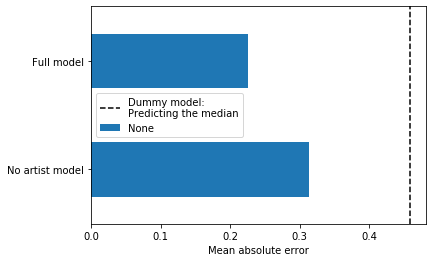

In [103]:
dummy_error = posterior['LogBoost'].sub(posterior['LogBoost'].median()).abs().mean()
maes = pd.Series(
        {
            'No artist model': posterior['abserror_without_artisteffect'].mean(),
            'Full model': posterior['abserror'].mean(),
        })
ax = maes.plot(kind='barh')
ax.axvline(dummy_error, c='k', ls='--', label='Dummy model:\nPredicting the median')
ax.set_xlabel('Mean absolute error')
plt.legend()
plt.show()

We see that both models are much better that a dummy model that predicts the median always. We do see however that we lose quite a bit of information that is in the artist specific model. There is not much we can do about that.

#### Information in the artist specific effect

We see that the artist effect on average improves the prediction by ~10%, but there are also cases where it worsens the prediction, and where it improves the predicting by more than 50%.

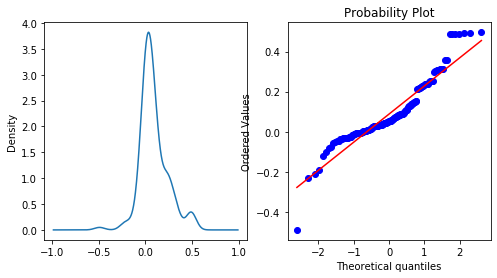

count    153.000000
mean       0.088299
std        0.146450
min       -0.490238
25%        0.005675
50%        0.052425
75%        0.141180
max        0.496162
Name: improvement_artisteffect, dtype: float64

In [104]:
plot_distribution(posterior['improvement_artisteffect'])

We see the distribution for the artist effect strength is standard normally distributed. On further inspection, we see that Michael Jackson received the strongest boost - which makes sense considering the soap around his death, and Joe Cocker and Liesbeth List got smaller boosts than expected.

In [105]:
codes, artistnames = pd.factorize(df['NameArtist'])
mapping = {c: a for c, a in zip(set(codes), artistnames)}

In [106]:
artist_magic = multilevel_noncentered_model_idata.posterior.to_dataframe().groupby('Artist')['za_artist'].describe()
artist_magic.index = artist_magic.index.map(mapping)
artist_magic.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
Artist,,,,,,,,
Joe Cocker,20000.0,-1.319954,0.630866,-4.183021,-1.735560,-1.321323,-0.899946,1.379178
Liesbeth List,20000.0,-1.251835,0.828093,-4.263010,-1.802786,-1.265811,-0.706265,2.380967
Charles Aznavour,20000.0,-0.994186,0.796264,-4.045423,-1.532655,-0.999859,-0.465879,2.180035
Donna Summer,20000.0,-0.891958,0.695869,-3.586560,-1.351107,-0.892438,-0.436432,1.868054
George Harrison,20000.0,-0.585951,0.909569,-4.559370,-1.200084,-0.588041,0.021025,2.877007
...,...,...,...,...,...,...,...,...
Johnny Cash,20000.0,0.995043,0.742340,-2.172558,0.501319,1.001447,1.497336,3.834847
George Michael,20000.0,1.013709,0.605167,-1.633956,0.615478,1.007059,1.406142,3.779423
Herman Brood,20000.0,1.049908,0.816547,-2.761467,0.508631,1.051777,1.599754,4.048269


# In depth explanation of predictions

While we have looked at the model globally, to get a more concrete view we also look into specific cases. To do this, we select 'representative samples', so we do not have to look into 153 songs.

## Finding representative samples
First, we select representative samples. There are many ways to do this, but since we are using a linear-regression-like model it works best if the input data is as different for the two samples as possible.

To do this, we compute the distances between input parameter of each of the 153 songs of passed away artists. For the recency effect, we first transform it to account for the fact that the relation is exponential. Also we transform all variables to a unit scale, so every variable weighs evenly.

Then we select all songs that have an error that smaller than or equal to the mean absolute error (approximately), because then we will understand why the model chose the prediction, and we select songs by artists that are at least moderately popular, so they will be known to the public.




In [107]:
variables = ['JarenGeleden',
             'LogPopularityNorm',
             'IsDutchArtist',
             'PassingTooEarly',
             'DaysEffect',
             'LogSongPopularityWithinArtist',
             'MultiplePerformers',          
             'LogBoost']
mm = sklearn.preprocessing.MinMaxScaler()

all_data = (posterior
            .assign(DaysEffect = lambda df: df_recencyeffect.mean(axis='columns').loc[df['DaysToStemperiode'].clip(lower=-365)].tolist())
            .filter(variables)
            )
mm.fit(all_data)

data = (posterior
        .query('abserror < 0.15 & LogPopularityNorm > -0.3 & DaysToStemperiode < -2')
        .query('Title != "Never Be Clever"') # Exclude this song because
        .assign(DaysEffect = lambda df: df_recencyeffect.mean(axis='columns').loc[df['DaysToStemperiode'].clip(lower=-365)].tolist())
        .filter(variables)
       )
data.head()

,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,DaysEffect,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost
1317,-4.0,1.433461,0,10.995209,1.005429,0.748454,0,0.905117
1339,-4.0,1.433461,0,10.995209,1.005429,0.336116,1,0.684489
1361,-4.0,1.433461,0,10.995209,1.005429,0.472535,0,0.919271
1426,-4.0,1.433461,0,10.995209,1.005429,-0.256398,0,0.791128
1447,-4.0,1.433461,0,10.995209,1.005429,-0.326231,1,0.649642


In [108]:
normalized_data = mm.transform(data)
dists = sklearn.metrics.pairwise_distances(normalized_data, metric='minkowski', p=1)
inds = np.argsort(dists, axis=None)[::-1]

We look at the Top 5 of song pairs which are as different as popular. We exclude the first pair of Montserrat Caballé and André Hazes, because Caballé was only noted with a duet with Freddy Mercury, which is already a bit off, but mostly because she passed away in the year the movie _Bohemian Rhapsody_ was released, which may have caused a boost for everything that's Queen-related. Therefore, we select the second-most different pair of David Bowie's _Under Pressure_ (a duet, Bowie passed away only 4 years ago) and André Hazes (passed away longer ago, is Dutch, passed away relatively shortly before the Top 2000 voting period and while he was younger). Unfortunately, the difference in popularity is quite small, but that is a compromise we must be willing to accept.

In [109]:
boosting_effects = ['LogBoost', 'yhat', 'error','yhat_no_artist', 'error_without_artisteffect']
variables = [v for v in variables if v != 'DaysEffect']
# Use step size of 2 because of symmetry: each pair is present twice
for ind in inds[:10:2]:
    x, y = divmod(ind, len(data))
    print(f'Distance: {dists[x, y]:.3f}; ({x}, {y})')
    ind = data.iloc[[x, y]].index

    new_df = pd.concat([df.assign(pos = range(len(df)))[['NameSong', 'Title', 'LogBoost', 'BoostSong', 'DaysToStemperiode', 'pos'] + variables],
                        posterior[boosting_effects]], axis='columns')
    display(new_df.loc[ind])

Distance: 4.071; (26, 21)


,NameSong,Title,LogBoost,BoostSong,DaysToStemperiode,pos,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost,LogBoost,yhat,error,yhat_no_artist,error_without_artisteffect
14217,André Hazes,Eenzame Kerst,0.753124,2.123623,-78,76,-16.0,1.065014,1,26.765229,-0.525191,0,0.753124,0.753124,0.751452,-0.001672,0.835491,0.082368
10901,Montserrat Caballé,Barcelona,0.333144,1.395349,-62,57,-2.0,0.495821,0,0.000000,0.000000,1,0.333144,0.333144,0.467166,0.134022,0.526774,0.193629


Distance: 3.833; (26, 1)


,NameSong,Title,LogBoost,BoostSong,DaysToStemperiode,pos,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost,LogBoost,yhat,error,yhat_no_artist,error_without_artisteffect
14217,André Hazes,Eenzame Kerst,0.753124,2.123623,-78,76,-16.0,1.065014,1,26.765229,-0.525191,0,0.753124,0.753124,0.751452,-0.001672,0.835491,0.082368
1339,David Bowie,Under Pressure,0.684489,1.982759,-327,1,-4.0,1.433461,0,10.995209,0.336116,1,0.684489,0.684489,0.632796,-0.051693,0.665405,-0.019084


Distance: 3.711; (27, 26)


,NameSong,Title,LogBoost,BoostSong,DaysToStemperiode,pos,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost,LogBoost,yhat,error,yhat_no_artist,error_without_artisteffect
15442,Aretha Franklin,I Knew You Were Waiting (for Me),0.612832,1.845650,-113,81,-2.0,0.562811,0,3.605749,-0.282935,1,0.612832,0.612832,0.655662,0.042830,0.434882,-0.177949
14217,André Hazes,Eenzame Kerst,0.753124,2.123623,-78,76,-16.0,1.065014,1,26.765229,-0.525191,0,0.753124,0.753124,0.751452,-0.001672,0.835491,0.082368


Distance: 3.647; (59, 4)


,NameSong,Title,LogBoost,BoostSong,DaysToStemperiode,pos,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost,LogBoost,yhat,error,yhat_no_artist,error_without_artisteffect
37989,Robert Long,Kalverliefde,0.270509,1.310631,-352,142,-13.0,0.286634,1,16.856947,0.169443,0,0.270509,0.270509,0.290813,0.020304,0.343238,0.072729
1447,David Bowie,Dancing in the Street,0.649642,1.914855,-327,6,-4.0,1.433461,0,10.995209,-0.326231,1,0.649642,0.649642,0.619868,-0.029774,0.647225,-0.002417


Distance: 3.565; (26, 25)


,NameSong,Title,LogBoost,BoostSong,DaysToStemperiode,pos,JarenGeleden,LogPopularityNorm,IsDutchArtist,PassingTooEarly,LogSongPopularityWithinArtist,MultiplePerformers,LogBoost,LogBoost,yhat,error,yhat_no_artist,error_without_artisteffect
14217,André Hazes,Eenzame Kerst,0.753124,2.123623,-78,76,-16.0,1.065014,1,26.765229,-0.525191,0,0.753124,0.753124,0.751452,-0.001672,0.835491,0.082368
12388,Joe Cocker,Up Where We Belong,-0.051688,0.949625,-340,67,-5.0,0.764706,0,9.409993,-0.358986,1,-0.051688,-0.051688,0.039195,0.090884,0.350462,0.402150


## Figuring out the boost for two songs

Finally we can for these two songs calculate how the boost came about; since we are using a linear model on the log boost, we can multiply the effects in the linear space.

In [110]:
def preprocess(df, include_difference):
    df = df.assign(TotalEffect = lambda df: df['EffectSize'].cumprod(),
                   Diff = lambda df: df['TotalEffect'].diff().fillna(df['TotalEffect']))
    return df

In [111]:
def find_colours(data, mask_from, including_difference):
    if mask_from is None:
        if including_difference:
            c = ['gray'] + (len(data) - 4) * ['lightgray'] + ['purple', 'red', 'purple']
            return c
        else:
            mask_from = len(data)
    if mask_from == 1:
        c =  ['purple']
    elif mask_from <= len(data):
        c = ['gray'] + (mask_from - 2) * ['lightgray'] + ['purple']
    return c
    
def plot_waterfall(effects, mask_from, including_difference=False, ax=None, horizontal=False):
    if ax is None:
        fig, ax = plt.subplots()
    data = effects.copy()
    #Store data and create a blank series to use for the waterfall
    total = data['Diff'].sum()

    if mask_from is not None:
        data.iloc[mask_from:] = None
    blank = data['Diff'].cumsum().shift(1).fillna(0)

    #Get the net total number for the final element in the waterfall
    if mask_from is None:
        data.loc[("Total", ''), 'EffectSize'] = 1
        data.loc[("Total", ''), 'Diff'] = total
        data.loc[("Total", ''), 'TotalEffect'] = total
        blank.loc["Total"] = total # This is only to get the steps right - it will later correctly be set to 0

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan
    if mask_from is None:
        blank.loc["Total"] = 0
    else:
        step.iloc[mask_from * 3:] = None
    
    if including_difference:
        blank.loc[('Prediction', '')] = 0
        data.loc[('Prediction', ''), 'Diff'] = data.loc[('Prediction', ''), 'TotalEffect']

    #Plot and label
    colours = find_colours(data, mask_from, including_difference)
    kind = 'bar' if not horizontal else 'barh'
    ax = data['Diff'].plot(kind=kind,
                           stacked=True,
                           bottom=blank,
                           left=blank,
                           legend=None,
                           color=colours,
                           ax=ax)
    if horizontal:
        ax.plot(step.values, step.index, 'k', linewidth=1)
    else:
        ax.plot(step.index, step.values, 'k', linewidth=1)

    #Get the y-axis position for the labels
    y_height = data['Diff'].cumsum().shift(1).fillna(0)

    #Get an offset so labels don't sit right on top of the bar
    vmax = data['Diff'].max()
    neg_offset = vmax / 25
    pos_offset = vmax / 50
    
    #Start label loop
    loop = 0
    for index, row in data.iterrows():
        # For the last item in the list, we don't want to double count
        y = row['TotalEffect']
        # Determine if we want a neg or pos offset
        if row['Diff'] >= 0:
            y += pos_offset
            va = 'bottom'
            ha = 'left'
        else:
            y -= neg_offset
            va = 'top'
            ha = 'right'
        if index not in [('Prediction', ''), ('Total', '')]:
            label = f'x {row["EffectSize"]:.2f}'
        else:
            label = ''
        if loop > 0:
            label += f'\n= {row["TotalEffect"] : .2f}'
        if horizontal:
            ax.annotate(label, (y, loop), va="center", ha=ha, fontsize=11)
        else:
            ax.annotate(label, (loop, y), ha="center", va=va, fontsize=11)
        loop += 1

    #Scale up the axis so there is room for the labels
    if horizontal:
        ax.axvline(1, c='k', ls='--')
        ax.set_xlim(0, 3)
    else:
        ax.axhline(1, c='k', ls='--')
        ax.set_ylim(0, 3)
    
    labels = ['Base',
              'Historical\neffect',
              'Popularity\neffect',
              'Artist is\nDutch',
              'Artist\ndied young',
              'Timing of\ndeath',
              'Artist\ndeviation',
              'Song popularity\nwithin artist oeuvre',
              'Multiple\nperformers',
              'Prediction'
              ]
    if including_difference:
        labels += ['Difference from\nactual boost', 'Actual boost']
    if horizontal:
        ax.set_yticklabels(labels)
        ax.invert_yaxis()
    else:
        ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if horizontal:
        ax.set_xlabel('Boost', fontsize=14)
        ax.set_ylabel('Effects', fontsize=14)
    else:
        ax.set_ylabel('Boost', fontsize=14)
        ax.set_xlabel('Effects', fontsize=14)
    return ax

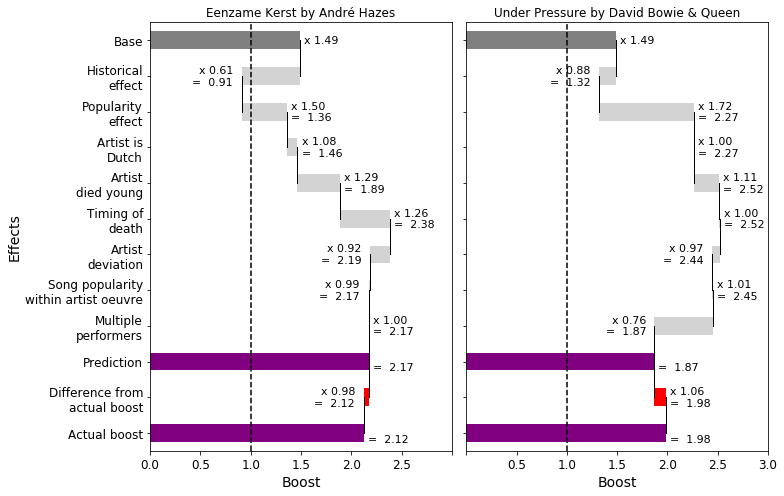

In [112]:
focus = None
song_pos = 76
explanation = b.all_effects(song_pos)
data_eenzamekerst = explanation.pipe(preprocess, False)
data_eenzamekerst_incl_diff = b.all_effects(song_pos, True, multilevel_noncentered_model_idata).pipe(preprocess, True)

song_pos = 1
explanation = b.all_effects(song_pos)
data_underpressure = explanation.pipe(preprocess, False)
data_underpressure_incl_diff = b.all_effects(song_pos, True, multilevel_noncentered_model_idata).pipe(preprocess, True)

fig, subplots = plt.subplots(1, 2, figsize=(11, 7))
ax = plot_waterfall(data_eenzamekerst_incl_diff, focus, True, subplots[0], True)
ax.set_title('Eenzame Kerst by André Hazes')
plt.setp(ax.get_xticklabels()[-1], visible=False)

ax2 = plot_waterfall(data_underpressure_incl_diff, focus, True, subplots[1], True)
ax2.set_title('Under Pressure by David Bowie & Queen')
ax2.set_yticklabels([])
ax2.set_ylabel('')
plt.setp(ax2.get_xticklabels()[0], visible=False)
plt.subplots_adjust(wspace=1e-2)

plt.tight_layout()
plt.savefig(f'EffectsEKUP_incl_diff_horizontal.jpg')

For a full description of this plot, see the [blog](https://sjoerdcornelissen.com/2021/03/02/the-effect-of-passing-away-on-top-2000-ranking/). Finally, we make this plot where we mask the final bars to make it easier to look at

In [113]:
fig, ax = plt.subplots(figsize=(6, 7))
plot_waterfall(data_eenzamekerst, 1, False, horizontal=True, ax=ax)
plt.tight_layout()
plt.savefig(f'Effects_base_horizontal.jpg')
plt.close(fig)

In [114]:
for focus in list(range(2, len(data_eenzamekerst) + 1)) + [None]:
    fig, subplots = plt.subplots(1, 2, figsize=(11, 7))
    
    ax = plot_waterfall(data_eenzamekerst, focus, False, subplots[0], True)
    ax.set_title('Eenzame Kerst by André Hazes')
    plt.setp(ax.get_xticklabels()[-1], visible=False)

    ax2 = plot_waterfall(data_underpressure, focus, False, subplots[1], True)
    ax2.set_title('Under Pressure by David Bowie & Queen')
    ax2.set_yticklabels([])
    ax2.set_ylabel('')
    plt.setp(ax2.get_xticklabels()[0], visible=False)
    
    plt.subplots_adjust(wspace=1e-2)
    plt.tight_layout()
    plt.savefig(f'EffectsEKUP_focus_{focus}_horizontal.jpg')
    plt.close(fig) # Do not show

In [115]:
focus = None
song_pos = 49
explanation = b.all_effects(song_pos, True, multilevel_noncentered_model_idata).pipe(preprocess, True)
data_carelesswhisper = explanation.pipe(preprocess, False)

In [117]:
df.assign(pos = range(len(df))).query('NameSong == "George Michael"')

,SongID,Year,Rank,Title,YearMadeSong,LinkSong,ArtistID,NameSong,LinkArtist,Act(s),...,EindeStemperiodeArtist,DaysToStemperiode,YearsSinceLastHit,LogPopularity,LogPopularityNorm,BoostArtist,LogBoost,SongRelativeBoost,LogRelativeBoost,pos
10654,3040274860339304845,2017,232.0,Careless Whisper,1984,https://nl.wikipedia.org/wiki/Careless_Whisper,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,0.901624,0.771590,-0.374094,49
10676,-983140255087496339,2017,714.0,Don't Let the Sun Go Down on Me,1991,https://nl.wikipedia.org/wiki/Don%27t_Let_the_...,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,0.555570,0.545880,-0.873345,50
10698,-3283153528300491266,2017,564.0,A Different Corner,1986,https://nl.wikipedia.org/wiki/A_Different_Corner,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,0.846816,0.730438,-0.453165,51
10731,2613746005776454046,2017,648.0,Faith,1987,https://nl.wikipedia.org/wiki/Faith_(nummer_va...,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,0.884780,0.758702,-0.398394,52
10749,-7359283231697910940,2017,317.0,Jesus to a Child,1996,https://nl.wikipedia.org/wiki/Jesus_to_a_Child,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,1.382675,1.248258,0.319916,53
10765,-5570684961462281827,2017,412.0,Cowboys and Angels,1990,https://nl.wikipedia.org/wiki/Cowboys_and_Angels,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,1.085679,0.927515,-0.108558,54
10777,6963337430297225114,2017,536.0,Father Figure,1988,https://nl.wikipedia.org/wiki/Father_Figure,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,1.053356,0.898013,-0.155192,55
10797,3161429615178487478,2017,135.0,Somebody to Love,1993,https://nl.wikipedia.org/wiki/Somebody_to_Love,3688892764874767065,George Michael,https://nl.wikipedia.org/wiki/George_Michael,None,...,2017-12-08,-348,24.0,-2.840172,0.701572,3.192889,1.887624,2.068239,1.048403,56


In [118]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BCA39AC4F0>,
      dtype=object)

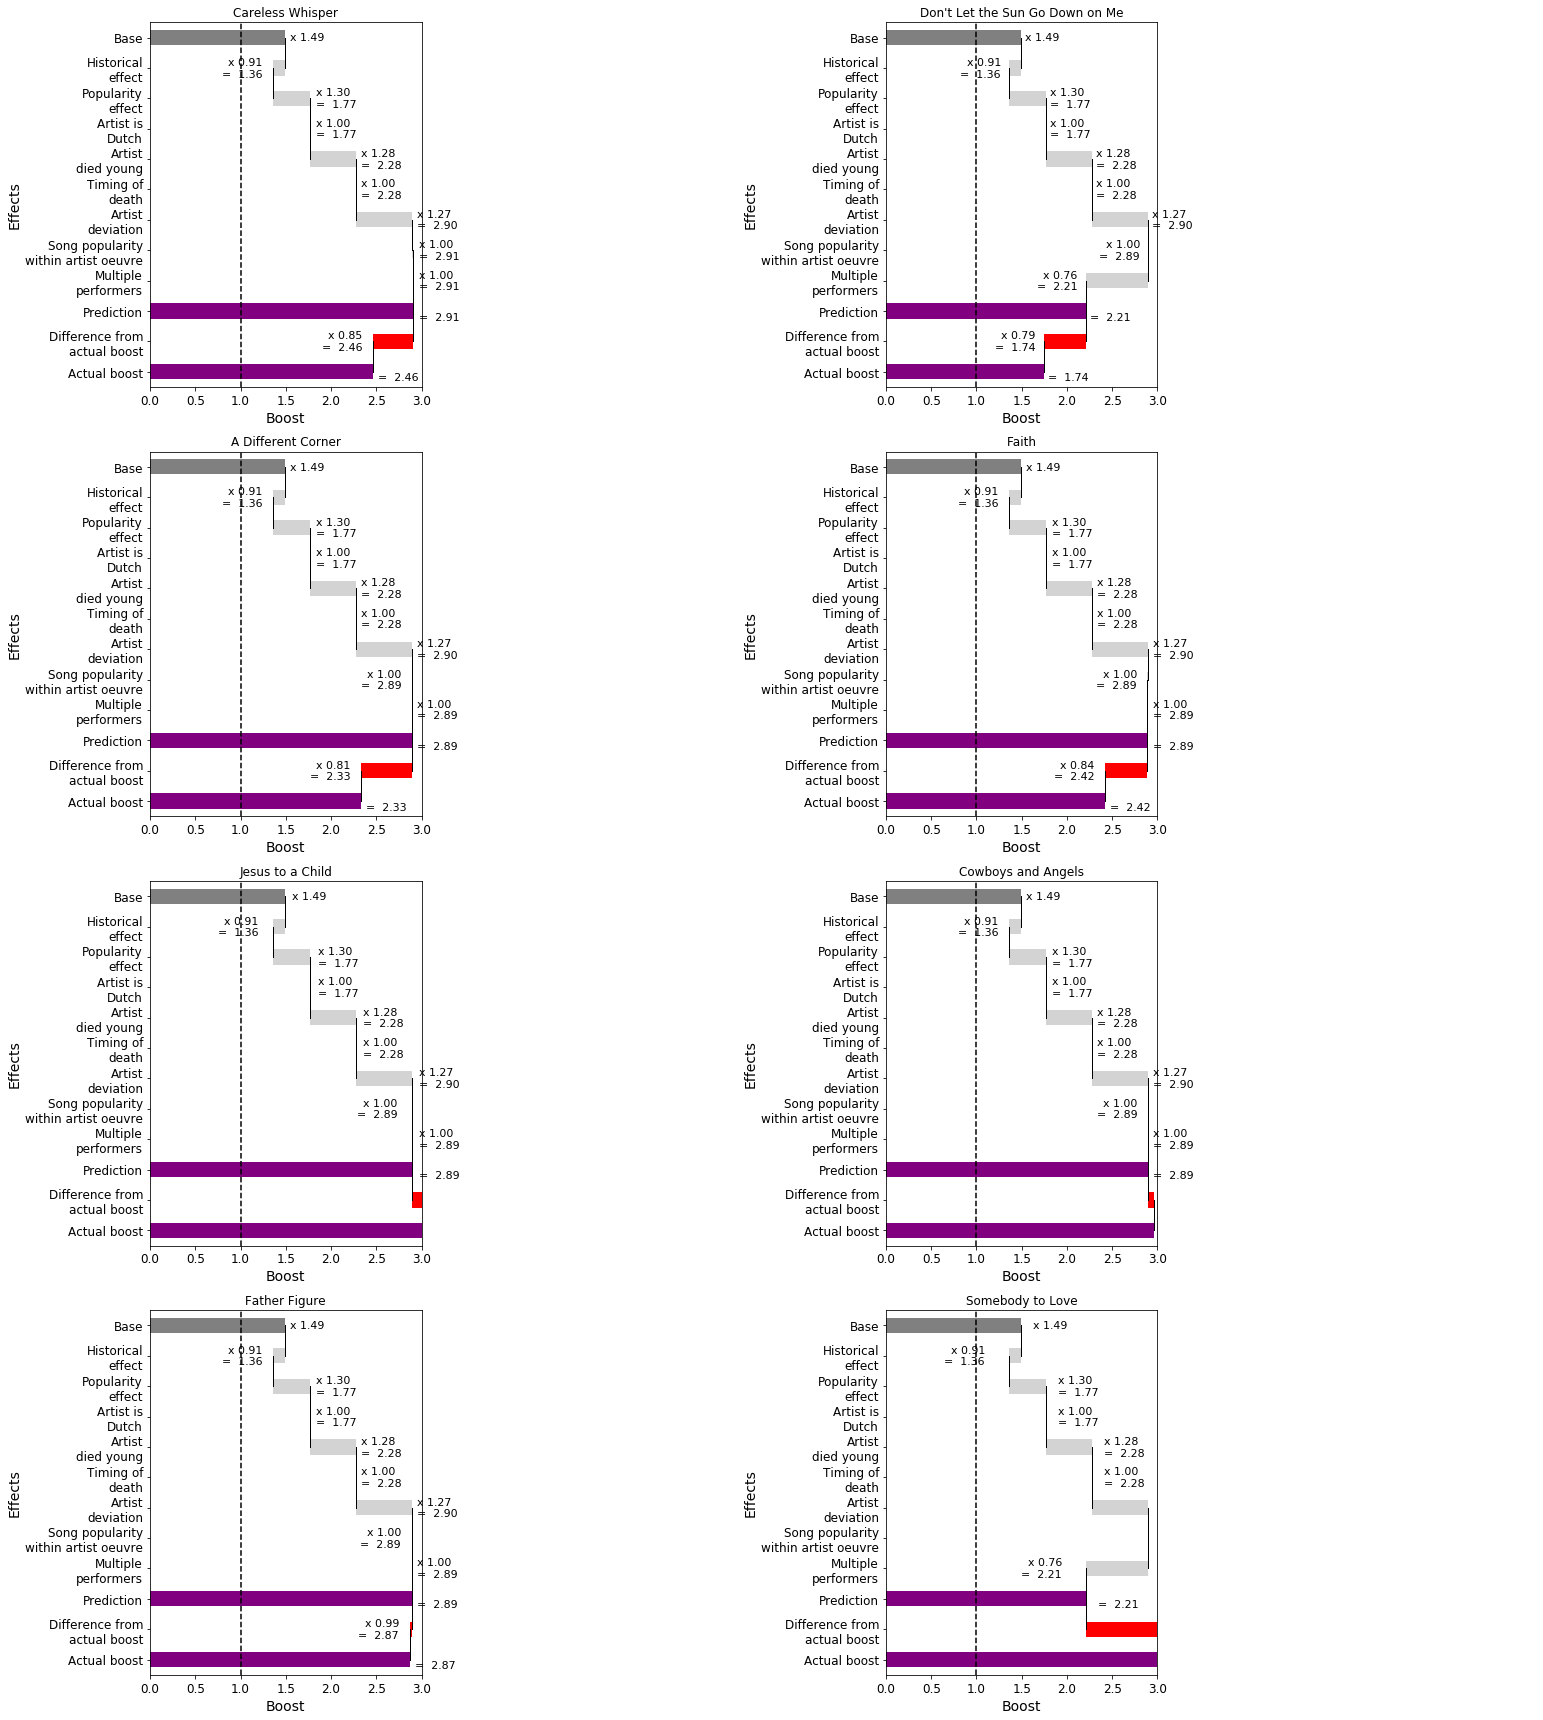

In [119]:
fig, axes = plt.subplots(4, 2, figsize=(30, 24))

for ax, pos in zip(axes.flatten(), range(49, 57)): 
    focus = None
    song_pos = pos
    explanation = b.all_effects(song_pos, True, multilevel_noncentered_model_idata).pipe(preprocess, True)
    data_carelesswhisper = explanation.pipe(preprocess, False)
    plot_waterfall(data_carelesswhisper, None, horizontal=True, including_difference=True, ax=ax)
    ax.set_title(df.iloc[song_pos].loc['Title'])
plt.tight_layout()

# Predicting unseen instances
While the main goal of this exercise was _inference_ (estimate what affects the size of the boost), I will quickly show how to predict theoretical new instances. This is specifically interesting because some parameters are fundanmentally unknowable beforehand, because they belong to new groups (i.e. new artists passing away): the artist specific boost is always known only after the oublishing of the official Top 2000.

This turns out to be relatively straight forward, since we made a model factory earlier:
1. Give the new data as arguments to the model factory
1. Importantly, we must drop the group-level parameters, which relate to specific artist, since they are unknown
1. Sample from the posterior predictive, which will generate one prediction for every sample from the Markov Chain Monte Carlo; the mean and its uncertainty give the predicted boost for each song

Somewhat surprisingly, PyMC3 requires two samples for every coordinate - and we have a coordinate for every song and every artist, so we require at least two unique artists.

In [120]:
%%time
# NOTE!! It only works with at least 2 different artists (which is far from perfect... but it is what it is)
df_new_data = df.tail(2).copy()
# We predict the boost for two songs, as if the artist passes away 100 years in the future
df_new_data['JarenGeleden'] = 100 

# Second comes the hold out data posterior predictive
with model_factory(X=df_new_data,
                   y=df_new_data['LogBoost'],
                   ) as prediction_model:
    # For newly passed artists, we do not know what za_artist should be
    # Again, the mysterious error for fast_sample pops up
    ppc_new_data = pm.sample_posterior_predictive(multilevel_noncentered_model_idata.posterior.drop_vars(['mu_artist', 'a_artist', 'za_artist']),
                                         var_names=['y_like'],
                                        )

Wall time: 2min 42s


Again we can add this to the InferenceData object, so we can easily use it in the future.

In [121]:
az.concat(multilevel_noncentered_model_idata, 
          az.from_pymc3_predictions(ppc_new_data, model=prediction_model), inplace=True)